# Bonus exercises

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset

# Define the device and data repository
device = 'cpu'
data_dir = 'data/'

### Exercise 1: MLP vs CNN

<img src="https://miro.medium.com/max/700/1*1Cw9nKcdKV5YQun-e4F8gQ.png" />
<center><a href="https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac">Source</a></center>

In lab 2 we have defined an MLP classifier, and in lab 3 we used a CNN classifier. A natural question is: how do they compare, and which one is the best? The goal of this exercise is to answer this question, in terms of number of parameters, training behavior, and accuracy on the test set.

In [19]:
# Load the Fashion MNIST dataset
train_data = datasets.FashionMNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(data_dir, train=False, download=True, transform=transforms.ToTensor())
num_classes = len(train_data.classes)

train_data = Subset(train_data, torch.arange(500))
test_data = Subset(test_data, torch.arange(50))

# Create dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for x in train_dataloader:
    print(x[0].shape)
    break

torch.Size([8, 1, 28, 28])


In [36]:
# TO DO: write the MLP and CNN (with batch norm) classifiers modules (you can reuse your code)

### MLP
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, act_fn):
        super(MLPClassif, self).__init__()
        
        # TO DO: define the two linear layers and the activation function
        self.lin1 = torch.nn.Linear(input_size, hidden_size)
        self.lin2 = torch.nn.Linear(hidden_size, output_size)
        self.activation = act_fn

    
    def forward(self, x):
        
        # TO DO: write the 'forward' method, which computes the output y from the input x
        # It should apply: layer1, the activation function, layer 2, and the activation function again
        #print('input mlp: ', x.shape)
        hidden = self.lin1(x)
        hidden_a = self.activation(hidden)
        output = self.lin2(hidden_a)
        output_a = self.activation(output)
        
        return output_a


### CNN
class CNNClassif_bnorm(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=10):
        super(CNNClassif_bnorm, self).__init__()
        
        # TO DO: define the convolutional layers 1 and 2 and the linear layer as above.
        self.cnn_layer1 = nn.Sequential(nn.Conv2d(1, num_channels1, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(num_features=num_channels1),
                           nn.MaxPool2d(kernel_size=2))
        self.cnn_layer2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(num_features=num_channels2),
                           nn.MaxPool2d(kernel_size=2))
        self.linear_layer = nn.Linear(num_channels2*7*7, num_classes)

        
    def forward(self, x):
        
        # TO DO: write the forward pass, which:
        # - applies the two cnn layers to produce feature maps
        # - vectorize the feature maps
        # - applies the linear layer
        out1 = self.cnn_layer1(x)
        #print("out1: ", out1.shape)
        out2 = self.cnn_layer2(out1)
        #print("out2: ", out2.shape)
        out_vec = out2.reshape(out2.shape[0], -1)
        #print("out_vec: ", out_vec.shape)
        out = self.linear_layer(out_vec)
        
        return out 

In [47]:
# TO DO: write the training function.
# No need to write 1 function for each module, you can use the same but be careful about vectorization.
def training_classifier(vectorize, model, train_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True):

    # Copy the model to the device and set it in 'training' mode (thus all gradients are computed)
    model = model.to(device)
    model.train()
    
    # Define the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            # TO DO: write the training procedure for each batch:
            if vectorize:
                # - vectorize the images (shape should be (batch_size, input_size))
                #print("before view: ", images.shape)
                images = images.view(images.size(0), 28*28)
                # - copy the data (images and labels) to the device
                images = images.to(device)
            images = images.to(device)
            labels = labels.to(device)
            # - apply the forward pass (calculate the predicted labels from the input images)
            y_pred = model(images)
            # - use the 'backward' method to compute the gradients
            loss = loss_fn(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            # - apply the gradient descent algorithm with the optimizer
            optimizer.step()
            # Also think of updating the loss at the current epoch
            loss_current_epoch += loss

        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch.item())
        if verbose:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
        
    return model, loss_all_epochs

In [48]:
# TO DO: write the evaluation function (again, no need to write 2)
def eval_classifier(vectorize, model, eval_dataloader, device):

    # Prepare the model (copy to device and disable some layers (batch norm, dropout...) when evaluating
    model.to(device)
    model.eval() 

    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct = 0
        total = 0
        for images, labels in eval_dataloader:
            if vectorize:
                images = images.reshape(images.shape[0], -1)
            images = images.to(device)
            labels = labels.to(device)
            y_predicted = model(images)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    
    return accuracy

In [49]:
# TO DO: For each model (MLP and CNN):
# - Define the parameters of the network
# - Instantiate the model
# - Train it (use the same optimizer, loss function and number of epochs for both)
# - Compute accuracy on the test set.

### MLP
input_size = 1*28*28 # vectorized images
hidden_size= 100
num_classes = 10
num_epochs = 20
act_fn = torch.nn.Softmax(dim=0)

classifier_mlp = MLPClassif(input_size, hidden_size, num_classes, act_fn)
classifier_mlp, loss_mlp = training_classifier(True, classifier_mlp, train_dataloader, num_epochs, torch.nn.CrossEntropyLoss(), 0.01)
torch.save(classifier_mlp.state_dict(), 'classifier.pt')
accuracy_mlp = eval_classifier(True, classifier_mlp, test_dataloader, device='cpu')


### CNN
num_channels1 = 16
num_channels2 = 32
num_classes = 10
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001
classifier_cnn = CNNClassif_bnorm(num_channels1, num_channels2, num_classes)
classifier_cnn, loss_cnn = training_classifier(False, classifier_cnn, train_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True)
torch.save(classifier_cnn.state_dict(), 'model_cnn_classif.pt')
accuracy_cnn = eval_classifier(False, classifier_cnn, test_dataloader, device='cpu')


print(f"Accuracy MLP: {accuracy_mlp}%\nAccuracy CNN: {accuracy_cnn}%")

Epoch [1/20], Loss: 145.0689
Epoch [2/20], Loss: 145.0632
Epoch [3/20], Loss: 145.0551
Epoch [4/20], Loss: 145.0469
Epoch [5/20], Loss: 145.0355
Epoch [6/20], Loss: 145.0299
Epoch [7/20], Loss: 145.0262
Epoch [8/20], Loss: 145.0212
Epoch [9/20], Loss: 145.0080
Epoch [10/20], Loss: 145.0046
Epoch [11/20], Loss: 144.9952
Epoch [12/20], Loss: 144.9863
Epoch [13/20], Loss: 144.9822
Epoch [14/20], Loss: 144.9775
Epoch [15/20], Loss: 144.9607
Epoch [16/20], Loss: 144.9559
Epoch [17/20], Loss: 144.9509
Epoch [18/20], Loss: 144.9438
Epoch [19/20], Loss: 144.9358
Epoch [20/20], Loss: 144.9284
Epoch [1/20], Loss: 99.6466
Epoch [2/20], Loss: 53.1513
Epoch [3/20], Loss: 41.3614
Epoch [4/20], Loss: 33.2876
Epoch [5/20], Loss: 27.9485
Epoch [6/20], Loss: 23.9004
Epoch [7/20], Loss: 21.5371
Epoch [8/20], Loss: 18.6304
Epoch [9/20], Loss: 16.4210
Epoch [10/20], Loss: 14.8931
Epoch [11/20], Loss: 12.9653
Epoch [12/20], Loss: 11.9312
Epoch [13/20], Loss: 11.0167
Epoch [14/20], Loss: 9.7799
Epoch [15/20]

Total number of parameters MLP:  79510
Total number of parameters CNN:  29034


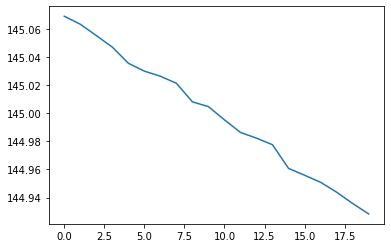

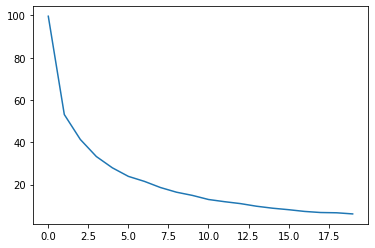

Accuracy MLP: 38.0%
Accuracy CNN: 70.0%


In [51]:
# TO DO: compare the MLP and CNN models
# - print the number of parameters of each model
print('Total number of parameters MLP: ', sum(p.numel() for p in classifier_mlp.parameters()))
print('Total number of parameters CNN: ', sum(p.numel() for p in classifier_cnn.parameters()))
# - plot the training loss
plt.plot(loss_mlp)
plt.show()
plt.plot(loss_cnn)
plt.show()
# - display accuracy
print(f"Accuracy MLP: {accuracy_mlp}%\nAccuracy CNN: {accuracy_cnn}%")

<img src="https://miro.medium.com/max/772/1*ztZn098tDQsnD5J6v1eNuQ.png" />
<center><a href="https://emkademy.medium.com/1-first-step-to-generative-deep-learning-with-autoencoders-22bd41e56d18">Source</a></center>

In lab 2.3 we have defined an MLP autoencoder. Here, we propose to do the same using CNNs. CNN autoencoders are very used in image processing applications such as image denoising, compression, and generative models (image synthesis and transformation). They can also be used for transfer learning: first an autoencoder is trained to learn a latent representation of images, and then this representation can be used for other classification/regression tasks.

In [79]:
# TO DO: create the autoencoder module (write the __init__ and forward methods)

# The encoder consists of two layers, with a convolution function, a RELU and a max pooling:
# ------ 1st layer -----
# convolution: 16 output channels, kernel_size=3, padding=1
# MaxPooling: kernel_size=2, stride=2
# ------ 2nd layer -----
# convolution: 4 output channels, kernel_size=3, padding=1
# MaxPooling: kernel_size=2, stride=2

# Then, the decoder has the same structure "in reverse" using transposed convolutions and RELU (no maxpooling):
# ------ 1st layer -----
# transposed convolution: 16 output channels, kernel_size=2, stride=2
# ------ 2nd layer -----
# transposed convolution: 1 output channel, kernel_size=2, stride=2

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # TO DO: define the convolutional layers 1 and 2 and the linear layer as above.
        self.enc_cnn_layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=3, padding=1),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2, stride=2))
        self.enc_cnn_layer2 = nn.Sequential(nn.Conv2d(16, 4, kernel_size=3, padding=1),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2, stride=2))
        self.dec_cnn_layer1 = nn.Sequential(nn.ConvTranspose2d(4, 16, kernel_size=2, stride=2),
                           nn.ReLU())
        self.dec_cnn_layer2 = nn.Sequential(nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
                           nn.ReLU())
        

        
    def forward(self, x):
        
        # TO DO: write the forward pass, which:
        # - applies the two cnn layers to produce feature maps
        # - vectorize the feature maps
        # - applies the linear layer
        out1 = self.enc_cnn_layer1(x)
        #print("out1: ", out1.shape)
        out2 = self.enc_cnn_layer2(out1)
        #print("out2: ", out2.shape)
        out3 = self.dec_cnn_layer1(out2)
        #print("out3: ", out3.shape)
        out = self.dec_cnn_layer2(out3)
        #print("out: ", out.shape)
        
        return out 


In [80]:
# TO DO: create the training function. It should resemble other training functions you have coded,
# but here you should use the Adam optimizer instead of SGD, see: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam
def training_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True):

    # Copy the model to the device and set it in 'training' mode (thus all gradients are computed)
    model = model.to(device)
    model.train()
    
    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            # TO DO: write the training procedure for each batch:
            images = images.to(device)
            labels = labels.to(device)
            # - apply the forward pass (calculate the predicted labels from the input images)
            y_pred = model(images)
            # - use the 'backward' method to compute the gradients
            #print(y_pred.shape, images.shape)
            loss = loss_fn(y_pred, images)
            optimizer.zero_grad()
            loss.backward()
            # - apply the gradient descent algorithm with the optimizer
            optimizer.step()
            # Also think of updating the loss at the current epoch
            loss_current_epoch += loss

        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch.item())
        if verbose:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
        
    return model, loss_all_epochs

In [81]:
# TO DO: Write the eval function (same as the MLP autoencoder, but without vectorization)
def eval_classifier(vectorize, model, eval_dataloader, device):

    # Prepare the model (copy to device and disable some layers (batch norm, dropout...) when evaluating
    model.to(device)
    model.eval() 

    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct = 0
        total = 0
        for images, labels in eval_dataloader:
            if vectorize:
                images = images.reshape(images.shape[0], -1)
            images = images.to(device)
            labels = labels.to(device)
            y_predicted = model(images)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    
    return accuracy

In [82]:
# TO DO:
# - instantiate the CNN autoencoder model
# - define the optimize parameters: 100 epochs, MSE loss function, learning_rate=0.001
# - train the model and evaluate it on the test set
num_epochs = 100
autoencoder = Autoencoder()
autoencoder, loss_mlp = training_classifier(autoencoder, train_dataloader, num_epochs, torch.nn.MSELoss(), 0.001)
torch.save(autoencoder.state_dict(), 'autoencoder.pt')
accuracy_mlp = eval_classifier(autoencoder, test_dataloader, device='cpu')

Epoch [1/100], Loss: 7.8343
Epoch [2/100], Loss: 2.4010
Epoch [3/100], Loss: 1.8246
Epoch [4/100], Loss: 1.5385
Epoch [5/100], Loss: 1.3394
Epoch [6/100], Loss: 1.2342
Epoch [7/100], Loss: 1.1865
Epoch [8/100], Loss: 1.1545
Epoch [9/100], Loss: 1.1288
Epoch [10/100], Loss: 1.1086
Epoch [11/100], Loss: 1.0931
Epoch [12/100], Loss: 1.0739
Epoch [13/100], Loss: 1.0607
Epoch [14/100], Loss: 1.0529
Epoch [15/100], Loss: 1.0449
Epoch [16/100], Loss: 1.0284
Epoch [17/100], Loss: 1.0216
Epoch [18/100], Loss: 1.0031
Epoch [19/100], Loss: 0.9932
Epoch [20/100], Loss: 0.9853
Epoch [21/100], Loss: 0.9797
Epoch [22/100], Loss: 0.9693
Epoch [23/100], Loss: 0.9643
Epoch [24/100], Loss: 0.9581
Epoch [25/100], Loss: 0.9461
Epoch [26/100], Loss: 0.9415
Epoch [27/100], Loss: 0.9327
Epoch [28/100], Loss: 0.9267
Epoch [29/100], Loss: 0.9217
Epoch [30/100], Loss: 0.9130
Epoch [31/100], Loss: 0.9125
Epoch [32/100], Loss: 0.9060
Epoch [33/100], Loss: 0.8978
Epoch [34/100], Loss: 0.8986
Epoch [35/100], Loss: 0

TypeError: eval_classifier() missing 1 required positional argument: 'eval_dataloader'

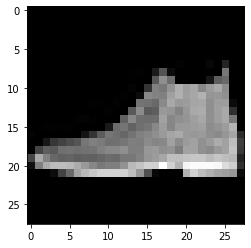

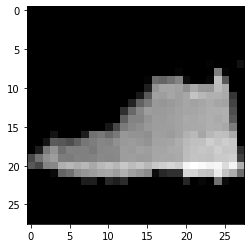

In [97]:
# TO DO: Vizualization of an example
# - load an image from the test dataset
# - pass it to the CNN autoencoder
# - plot the original and reconstructed images
for (images, labels) in test_dataloader:
    #print(images[0])
    image = images[0]
    out = autoencoder(image.unsqueeze(0))
    plt.figure()
    plt.imshow(image.squeeze(), cmap='gray')
    plt.show()
    plt.imshow(out.squeeze().detach().numpy(), cmap='gray')
    plt.show()
    break